- age, memmonths, R3 (and R3.na), allgames1yr, hasemail

- I found that the extra features make GAM better, but not the other features. I think because GAM can capture the shape of the distribution of the predictors better — the NN/RF/GLM can't

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.cross_validation import train_test_split
# true, then pred
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

import pickle
from sklearn.externals import joblib

In [2]:
from sknn.mlp import Classifier, Layer

In [3]:
import amyutility as p2

In [4]:
reload(p2)

<module 'amyutility' from 'amyutility.pyc'>

# Load Data

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
print train.shape
print test.shape

(43436, 23)
(14479, 23)


In [7]:
traink = pd.read_csv('data/fromKen/full_train_2.csv')
testk = pd.read_csv('data/fromKen/full_test_2.csv')

In [8]:
print traink.shape
print testk.shape

(43436, 56)
(14479, 55)


# Data Exploration

In [9]:
test.head()

,age,sex,region,nregions,memtype,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,Id
0,29.00,M,reg127,1,N,2,Y,N,N,nan,nan,2024.00,nan,N,N,nan,0,0,0,0,0,0,1
1,16.00,M,reg142,1,N,258,N,N,Y,2753.00,2751.00,2709.00,3528.00,N,N,nan,10,223,0,57,7,0,2
2,22.00,M,reg104,1,N,28,N,N,Y,nan,nan,1668.00,2910.00,N,N,nan,6,6,2,1,0,0,3
3,10.00,M,reg112,1,N,14,N,N,Y,nan,nan,741.00,1107.00,N,N,nan,13,13,0,2,1,0,4
4,14.00,F,reg106,1,N,131,N,N,N,359.00,325.00,531.00,654.00,N,N,nan,14,57,0,16,1,0,5


In [10]:
train.columns

Index([u'lapsed', u'age', u'sex', u'region', u'nregions', u'memtype', u'memmonths', u'mem_mag1', u'mem_mag2', u'hasemail', u'r1', u'r2', u'r3', u'r.quick', u'extra', u'intl', u'r.intl', u'allgames1yr', u'allgames5yr', u'fastevents', u'medevents', u'slowevents', u'nfloor'], dtype='object')

## Using Ken's Data

In [11]:
traink.columns

Index([u'lapsed', u'age', u'sex', u'region', u'nregions', u'memtype', u'memmonths', u'mem_mag1', u'mem_mag2', u'hasemail', u'r1', u'r2', u'r3', u'r.quick', u'extra', u'intl', u'r.intl', u'allgames1yr', u'allgames5yr', u'fastevents', u'medevents', u'slowevents', u'nfloor', u'age.na', u'r1.na', u'r2.na', u'r3.na', u'r.quick.na', u'r.intl.na', u'mon_less30', u'mon_31', u'mon_32', u'mon_33', u'mon_34', u'mon_35', u'mon_36', u'mon_37_60', u'mon_61_84', u'mon_85_120', u'mon_121_263', u'mon_264_plus',
       u'games_0', u'games_1_5', u'games_6_10', u'games_11_20', u'games_21_34', u'games_35_49', u'games_50_plus', u'agesq', u'agecbd', u'allgames1yrsq', u'allgames1yrcbd', u'allgames5yrsq', u'allgames5yrcbd', u'memmonthssq', u'memmonthscbd'],
      dtype='object')

In [12]:
testk.columns

Index([u'age', u'sex', u'region', u'nregions', u'memtype', u'memmonths', u'mem_mag1', u'mem_mag2', u'hasemail', u'r1', u'r2', u'r3', u'r.quick', u'extra', u'intl', u'r.intl', u'allgames1yr', u'allgames5yr', u'fastevents', u'medevents', u'slowevents', u'nfloor', u'age.na', u'r1.na', u'r2.na', u'r3.na', u'r.quick.na', u'r.intl.na', u'mon_less30', u'mon_31', u'mon_32', u'mon_33', u'mon_34', u'mon_35', u'mon_36', u'mon_37_60', u'mon_61_84', u'mon_85_120', u'mon_121_263', u'mon_264_plus',
       u'games_0', u'games_1_5', u'games_6_10', u'games_11_20', u'games_21_34', u'games_35_49', u'games_50_plus', u'agesq', u'agecbd', u'allgames1yrsq', u'allgames1yrcbd', u'allgames5yrsq', u'allgames5yrcbd', u'memmonthssq', u'memmonthscbd'],
      dtype='object')

In [13]:
traink.head()

,lapsed,age,sex,region,nregions,memtype,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,age.na,r1.na,r2.na,r3.na,r.quick.na,r.intl.na,mon_less30,mon_31,mon_32,mon_33,mon_34,mon_35,mon_36,mon_37_60,mon_61_84,mon_85_120,mon_121_263,mon_264_plus,games_0,games_1_5,games_6_10,games_11_20,games_21_34,games_35_49,games_50_plus,agesq,agecbd,allgames1yrsq,allgames1yrcbd,allgames5yrsq,allgames5yrcbd,memmonthssq,memmonthscbd
0,Y,11.00,M,0.12,1,N,19,N,N,N,1942.12,1811.61,1557.56,2007.74,N,N,3477.56,0,0,0,0,0,0,0,1,1,1,1,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4.97,7.45,0.00,0.00,0.00,0.00,5.99,8.99
1,N,61.00,M,0.12,1,N,198,Y,N,Y,2178.00,2215.00,2291.00,2932.00,Y,N,3477.56,4,29,1,0,10,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,8.25,12.38,3.22,4.83,6.80,10.20,10.59,15.88
2,Y,16.00,F,0.12,1,N,192,N,N,Y,627.00,628.00,1362.00,2007.00,N,N,3477.56,29,29,0,4,1,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,5.67,8.50,6.80,10.20,6.80,10.20,10.53,15.79
3,Y,47.00,M,0.12,1,N,268,Y,N,Y,2600.00,2601.00,2602.00,2007.74,N,N,3477.56,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,7.74,11.61,0.00,0.00,0.00,0.00,11.19,16.78
4,Y,11.00,F,0.12,1,N,101,N,N,N,464.00,466.00,958.00,1356.00,N,N,3477.56,12,35,0,8,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,4.97,7.45,5.13,7.69,7.17,10.75,9.25,13.87


In [14]:
testk.head()

,age,sex,region,nregions,memtype,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,age.na,r1.na,r2.na,r3.na,r.quick.na,r.intl.na,mon_less30,mon_31,mon_32,mon_33,mon_34,mon_35,mon_36,mon_37_60,mon_61_84,mon_85_120,mon_121_263,mon_264_plus,games_0,games_1_5,games_6_10,games_11_20,games_21_34,games_35_49,games_50_plus,agesq,agecbd,allgames1yrsq,allgames1yrcbd,allgames5yrsq,allgames5yrcbd,memmonthssq,memmonthscbd
0,29.00,M,0.11,1,N,2,Y,N,N,1942.12,1811.61,2024.00,2007.74,N,N,3477.56,0,0,0,0,0,0,0,1,1,0,1,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,6.80,10.20,0.00,0.00,0.00,0.00,2.20,3.30
1,16.00,M,0.02,1,N,258,N,N,Y,2753.00,2751.00,2709.00,3528.00,N,N,3477.56,10,223,0,57,7,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,5.67,8.50,4.80,7.19,10.82,16.23,11.11,16.67
2,22.00,M,0.00,1,N,28,N,N,Y,1942.12,1811.61,1668.00,2910.00,N,N,3477.56,6,6,2,1,0,0,0,1,1,0,0,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,6.27,9.41,3.89,5.84,3.89,5.84,6.73,10.10
3,10.00,M,0.12,1,N,14,N,N,Y,1942.12,1811.61,741.00,1107.00,N,N,3477.56,13,13,0,2,1,0,0,1,1,0,0,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,4.80,7.19,5.28,7.92,5.28,7.92,5.42,8.12
4,14.00,F,0.04,1,N,131,N,N,N,359.00,325.00,531.00,654.00,N,N,3477.56,14,57,0,16,1,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,5.42,8.12,5.42,8.12,8.12,12.18,9.77,14.65


In [15]:
traink_y = traink[['lapsed']]

In [16]:
traink_y.head()

,lapsed
0,Y
1,N
2,Y
3,Y
4,Y


In [17]:
traink_x = traink.drop('lapsed', axis=1)

In [18]:
traink_x.shape

(43436, 55)

In [19]:
traink_x.head()

,age,sex,region,nregions,memtype,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,age.na,r1.na,r2.na,r3.na,r.quick.na,r.intl.na,mon_less30,mon_31,mon_32,mon_33,mon_34,mon_35,mon_36,mon_37_60,mon_61_84,mon_85_120,mon_121_263,mon_264_plus,games_0,games_1_5,games_6_10,games_11_20,games_21_34,games_35_49,games_50_plus,agesq,agecbd,allgames1yrsq,allgames1yrcbd,allgames5yrsq,allgames5yrcbd,memmonthssq,memmonthscbd
0,11.00,M,0.12,1,N,19,N,N,N,1942.12,1811.61,1557.56,2007.74,N,N,3477.56,0,0,0,0,0,0,0,1,1,1,1,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4.97,7.45,0.00,0.00,0.00,0.00,5.99,8.99
1,61.00,M,0.12,1,N,198,Y,N,Y,2178.00,2215.00,2291.00,2932.00,Y,N,3477.56,4,29,1,0,10,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,8.25,12.38,3.22,4.83,6.80,10.20,10.59,15.88
2,16.00,F,0.12,1,N,192,N,N,Y,627.00,628.00,1362.00,2007.00,N,N,3477.56,29,29,0,4,1,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,5.67,8.50,6.80,10.20,6.80,10.20,10.53,15.79
3,47.00,M,0.12,1,N,268,Y,N,Y,2600.00,2601.00,2602.00,2007.74,N,N,3477.56,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,7.74,11.61,0.00,0.00,0.00,0.00,11.19,16.78
4,11.00,F,0.12,1,N,101,N,N,N,464.00,466.00,958.00,1356.00,N,N,3477.56,12,35,0,8,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,4.97,7.45,5.13,7.69,7.17,10.75,9.25,13.87


In [20]:
train_y = (traink_y.lapsed.values=='Y')*1

In [21]:
# key train_y
train_y

array([1, 0, 1, ..., 0, 1, 0])

In [22]:
# key test_ids: for writing to predictions
test_ids = test.Id.values
test_ids

array([    1,     2,     3, ..., 14477, 14478, 14479])

In [23]:
# key df_all: combine test and train into df_all, test_idx 
test_idx = traink_x.shape[0]
df_all = pd.concat((traink_x, testk), axis=0)

In [24]:
print df_all.shape
print test_idx

(57915, 55)
43436


#### Key: 
- df_all
- test_idx
- train_y
- test_ids

## Check Types and Convert

- need to convert sex, memtype, mem_mag1, mem_mag2, hasemail, extra, intl
- Can leave bools alone

In [25]:
# CONVERT = ['sex', 'memtype', 'mem_mag1', 'mem_mag2', 'hasemail', 'extra', 'intl']

### sex

- males 0
- females 1

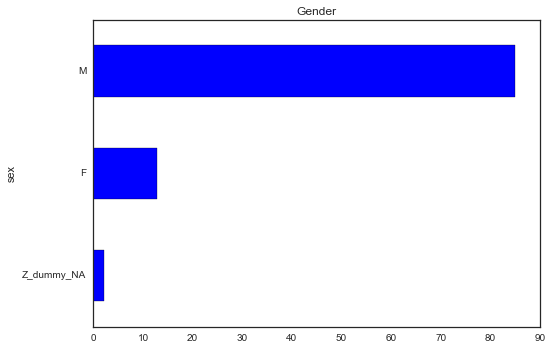

In [26]:
# mostly male (males 0, females 1)
gender = df_all.groupby('sex').size().sort_values(ascending = True)/df_all.shape[0]*100
gender.plot(kind='barh', title = 'Gender')
plt.show()

In [27]:
df_all.head()

,age,sex,region,nregions,memtype,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,age.na,r1.na,r2.na,r3.na,r.quick.na,r.intl.na,mon_less30,mon_31,mon_32,mon_33,mon_34,mon_35,mon_36,mon_37_60,mon_61_84,mon_85_120,mon_121_263,mon_264_plus,games_0,games_1_5,games_6_10,games_11_20,games_21_34,games_35_49,games_50_plus,agesq,agecbd,allgames1yrsq,allgames1yrcbd,allgames5yrsq,allgames5yrcbd,memmonthssq,memmonthscbd
0,11.00,M,0.12,1,N,19,N,N,N,1942.12,1811.61,1557.56,2007.74,N,N,3477.56,0,0,0,0,0,0,0,1,1,1,1,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4.97,7.45,0.00,0.00,0.00,0.00,5.99,8.99
1,61.00,M,0.12,1,N,198,Y,N,Y,2178.00,2215.00,2291.00,2932.00,Y,N,3477.56,4,29,1,0,10,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,8.25,12.38,3.22,4.83,6.80,10.20,10.59,15.88
2,16.00,F,0.12,1,N,192,N,N,Y,627.00,628.00,1362.00,2007.00,N,N,3477.56,29,29,0,4,1,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,5.67,8.50,6.80,10.20,6.80,10.20,10.53,15.79
3,47.00,M,0.12,1,N,268,Y,N,Y,2600.00,2601.00,2602.00,2007.74,N,N,3477.56,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,7.74,11.61,0.00,0.00,0.00,0.00,11.19,16.78
4,11.00,F,0.12,1,N,101,N,N,N,464.00,466.00,958.00,1356.00,N,N,3477.56,12,35,0,8,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,4.97,7.45,5.13,7.69,7.17,10.75,9.25,13.87


In [28]:
df_all.dtypes

age               float64
sex                object
region            float64
nregions            int64
memtype            object
memmonths           int64
mem_mag1           object
mem_mag2           object
hasemail           object
r1                float64
r2                float64
r3                float64
r.quick           float64
extra              object
intl               object
r.intl            float64
allgames1yr         int64
allgames5yr         int64
fastevents          int64
medevents           int64
slowevents          int64
nfloor              int64
age.na              int64
r1.na               int64
r2.na               int64
r3.na               int64
r.quick.na          int64
r.intl.na           int64
mon_less30           bool
mon_31               bool
mon_32               bool
mon_33               bool
mon_34               bool
mon_35               bool
mon_36               bool
mon_37_60            bool
mon_61_84            bool
mon_85_120           bool
mon_121_263 

In [29]:
df_all['sex']

0                 M
1                 M
2                 F
3                 M
4                 F
5                 F
6                 M
7                 M
8                 M
9                 M
10                M
11                M
12                M
13                M
14                M
15                F
16                M
17                M
18                F
19                M
20                M
21                F
22                M
23                M
24                M
25                M
26                M
27                M
28                F
29                M
30                M
31                M
32                M
33                F
34                M
35                M
36                M
37                M
38                M
39                F
40                M
41                M
42                M
43                F
44                M
45                M
46                M
47                M
48                M
49                M


In [30]:
df_all.sex = (df_all.sex.values=='F')*1

In [31]:
df_all.head()

,age,sex,region,nregions,memtype,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,age.na,r1.na,r2.na,r3.na,r.quick.na,r.intl.na,mon_less30,mon_31,mon_32,mon_33,mon_34,mon_35,mon_36,mon_37_60,mon_61_84,mon_85_120,mon_121_263,mon_264_plus,games_0,games_1_5,games_6_10,games_11_20,games_21_34,games_35_49,games_50_plus,agesq,agecbd,allgames1yrsq,allgames1yrcbd,allgames5yrsq,allgames5yrcbd,memmonthssq,memmonthscbd
0,11.00,0,0.12,1,N,19,N,N,N,1942.12,1811.61,1557.56,2007.74,N,N,3477.56,0,0,0,0,0,0,0,1,1,1,1,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4.97,7.45,0.00,0.00,0.00,0.00,5.99,8.99
1,61.00,0,0.12,1,N,198,Y,N,Y,2178.00,2215.00,2291.00,2932.00,Y,N,3477.56,4,29,1,0,10,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,8.25,12.38,3.22,4.83,6.80,10.20,10.59,15.88
2,16.00,1,0.12,1,N,192,N,N,Y,627.00,628.00,1362.00,2007.00,N,N,3477.56,29,29,0,4,1,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,5.67,8.50,6.80,10.20,6.80,10.20,10.53,15.79
3,47.00,0,0.12,1,N,268,Y,N,Y,2600.00,2601.00,2602.00,2007.74,N,N,3477.56,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,7.74,11.61,0.00,0.00,0.00,0.00,11.19,16.78
4,11.00,1,0.12,1,N,101,N,N,N,464.00,466.00,958.00,1356.00,N,N,3477.56,12,35,0,8,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,4.97,7.45,5.13,7.69,7.17,10.75,9.25,13.87


### memtype
- make Normal the reference category
- memtypeA=1 for affiliate
- memtypeF=1 for family

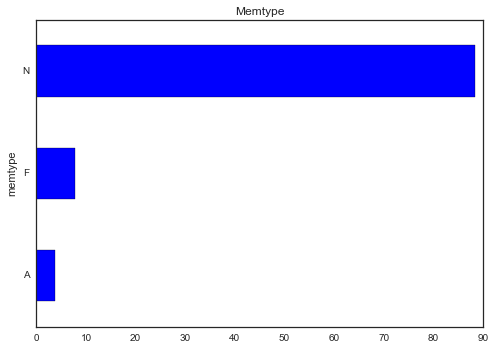

In [32]:
# membership types A, F, N 
memtype = df_all.groupby('memtype').size().sort_values(ascending = True)/df_all.shape[0]*100
memtype.plot(kind='barh', title = 'Memtype')
plt.show()

In [33]:
df_all['memtypeA'] = (df_all.memtype=='A')*1

In [34]:
df_all['memtypeF'] = (df_all.memtype=='F')*1

In [35]:
df_all = df_all.drop('memtype', axis=1)

### mem_mag1 & mem_mag2 & hasemail

- only yes or no... convert yes to 1, no to 0

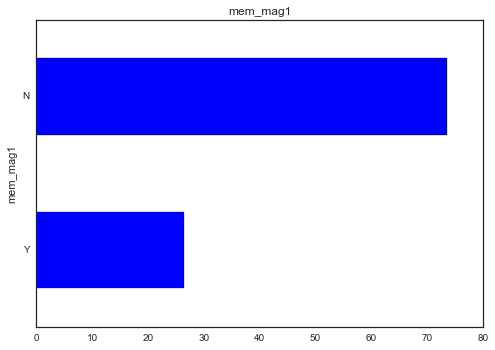

In [36]:
memmag1 = df_all.groupby('mem_mag1').size().sort_values(ascending = True)/df_all.shape[0]*100
memmag1.plot(kind='barh', title = 'mem_mag1')
plt.show()

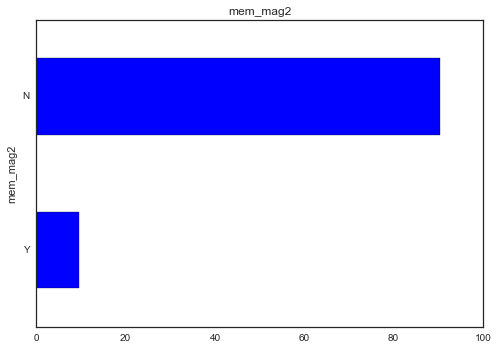

In [37]:
memmag2 = df_all.groupby('mem_mag2').size().sort_values(ascending = True)/df_all.shape[0]*100
memmag2.plot(kind='barh', title = 'mem_mag2')
plt.show()

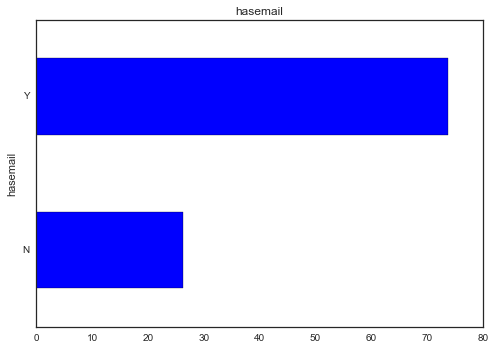

In [38]:
hasemail = df_all.groupby('hasemail').size().sort_values(ascending = True)/df_all.shape[0]*100
hasemail.plot(kind='barh', title = 'hasemail')
plt.show()

In [39]:
df_all.mem_mag1 = (df_all.mem_mag1.values=='Y')*1
df_all.mem_mag2 = (df_all.mem_mag2.values=='Y')*1

In [40]:
df_all.hasemail = (df_all.hasemail.values=='Y')*1

In [41]:
df_all.head()

,age,sex,region,nregions,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,age.na,r1.na,r2.na,r3.na,r.quick.na,r.intl.na,mon_less30,mon_31,mon_32,mon_33,mon_34,mon_35,mon_36,mon_37_60,mon_61_84,mon_85_120,mon_121_263,mon_264_plus,games_0,games_1_5,games_6_10,games_11_20,games_21_34,games_35_49,games_50_plus,agesq,agecbd,allgames1yrsq,allgames1yrcbd,allgames5yrsq,allgames5yrcbd,memmonthssq,memmonthscbd,memtypeA,memtypeF
0,11.00,0,0.12,1,19,0,0,0,1942.12,1811.61,1557.56,2007.74,N,N,3477.56,0,0,0,0,0,0,0,1,1,1,1,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4.97,7.45,0.00,0.00,0.00,0.00,5.99,8.99,0,0
1,61.00,0,0.12,1,198,1,0,1,2178.00,2215.00,2291.00,2932.00,Y,N,3477.56,4,29,1,0,10,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,8.25,12.38,3.22,4.83,6.80,10.20,10.59,15.88,0,0
2,16.00,1,0.12,1,192,0,0,1,627.00,628.00,1362.00,2007.00,N,N,3477.56,29,29,0,4,1,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,5.67,8.50,6.80,10.20,6.80,10.20,10.53,15.79,0,0
3,47.00,0,0.12,1,268,1,0,1,2600.00,2601.00,2602.00,2007.74,N,N,3477.56,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,7.74,11.61,0.00,0.00,0.00,0.00,11.19,16.78,0,0
4,11.00,1,0.12,1,101,0,0,0,464.00,466.00,958.00,1356.00,N,N,3477.56,12,35,0,8,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,4.97,7.45,5.13,7.69,7.17,10.75,9.25,13.87,0,0


### extra, intl

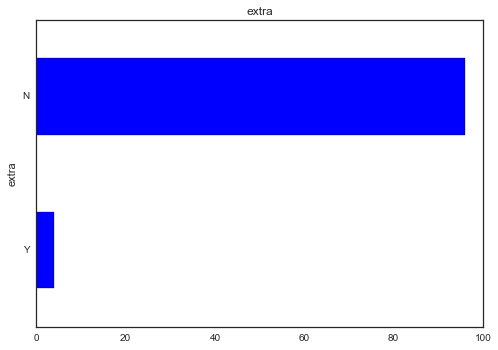

In [42]:
extra = df_all.groupby('extra').size().sort_values(ascending = True)/df_all.shape[0]*100
extra.plot(kind='barh', title = 'extra')
plt.show()

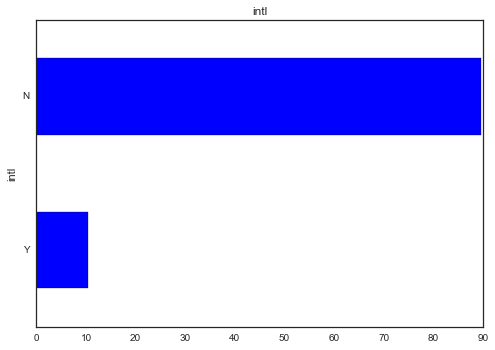

In [43]:
intl = df_all.groupby('intl').size().sort_values(ascending = True)/df_all.shape[0]*100
intl.plot(kind='barh', title = 'intl')
plt.show()

In [44]:
df_all.extra = (df_all.extra.values=='Y')*1
df_all.intl = (df_all.intl.values=='Y')*1

In [45]:
df_all.head()

,age,sex,region,nregions,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,age.na,r1.na,r2.na,r3.na,r.quick.na,r.intl.na,mon_less30,mon_31,mon_32,mon_33,mon_34,mon_35,mon_36,mon_37_60,mon_61_84,mon_85_120,mon_121_263,mon_264_plus,games_0,games_1_5,games_6_10,games_11_20,games_21_34,games_35_49,games_50_plus,agesq,agecbd,allgames1yrsq,allgames1yrcbd,allgames5yrsq,allgames5yrcbd,memmonthssq,memmonthscbd,memtypeA,memtypeF
0,11.00,0,0.12,1,19,0,0,0,1942.12,1811.61,1557.56,2007.74,0,0,3477.56,0,0,0,0,0,0,0,1,1,1,1,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4.97,7.45,0.00,0.00,0.00,0.00,5.99,8.99,0,0
1,61.00,0,0.12,1,198,1,0,1,2178.00,2215.00,2291.00,2932.00,1,0,3477.56,4,29,1,0,10,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,8.25,12.38,3.22,4.83,6.80,10.20,10.59,15.88,0,0
2,16.00,1,0.12,1,192,0,0,1,627.00,628.00,1362.00,2007.00,0,0,3477.56,29,29,0,4,1,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,5.67,8.50,6.80,10.20,6.80,10.20,10.53,15.79,0,0
3,47.00,0,0.12,1,268,1,0,1,2600.00,2601.00,2602.00,2007.74,0,0,3477.56,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,7.74,11.61,0.00,0.00,0.00,0.00,11.19,16.78,0,0
4,11.00,1,0.12,1,101,0,0,0,464.00,466.00,958.00,1356.00,0,0,3477.56,12,35,0,8,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,4.97,7.45,5.13,7.69,7.17,10.75,9.25,13.87,0,0


# Feature Engineering

#### % change in chess rankings

In [46]:
df_all['r3r2'] = df_all.r3 / df_all.r2 -1

In [47]:
df_all['r3r1'] = df_all.r3 / df_all.r1 -1

In [48]:
df_all['allgames_change'] = df_all.allgames1yr/((df_all.allgames5yr - df_all.allgames1yr + 1)/4)-1

In [49]:
df_all['fastevets_prop'] = df_all.fastevents / (df_all.fastevents + df_all.medevents + df_all.slowevents+0.01)

In [50]:
df_all['medevents_prop'] = df_all.medevents / (df_all.fastevents + df_all.medevents + df_all.slowevents+0.01)

In [51]:
df_all['slowevents_prop'] = df_all.slowevents / (df_all.fastevents + df_all.medevents + df_all.slowevents+0.01)

In [52]:
# TODO region is discrete?? 
# last 8 are sq and cubed terms 
STANDARDIZE = ['age', 'region', 'nregions', 'memmonths', 'r1', 'r2', 'r3', 'r.quick', 'r.intl', 
               'allgames1yr', 'allgames5yr', 'fastevents', 'medevents', 'slowevents', 'nfloor', 
              'agesq', 'agecbd', 'allgames1yrsq', 'allgames1yrcbd', 'allgames5yrsq', 'allgames5yrcbd', 'memmonthssq', 
               'memmonthscbd', 'r3r2', 'r3r1', 'allgames_change', 'fastevets_prop', 'medevents_prop', 'slowevents_prop']


INDICATORS = ['sex', 'mem_mag1', 'mem_mag2', 'hasemail', 'extra', 'intl', 'age.na', 'r1.na', 'r2.na', 
             'r3.na', 'r.quick.na', 'r.intl.na', 'mon_less30', 'mon_31', 'mon_32', 'mon_33', 'mon_34', 
             'mon_35', 'mon_36', 'mon_37_60', 'mon_61_84', 'mon_85_120', 'mon_121_263', 'mon_264_plus', 
             'games_0', 'games_1_5', 'games_6_10', 'games_11_20', 'games_21_34', 'games_35_49', 'games_50_plus', 
             'memtypeA', 'memtypeF']

In [53]:
len(STANDARDIZE) + len(INDICATORS)

62

In [54]:
df_all.shape[1]

62

## Model Stacking

In [56]:
ms_train_x = pd.read_csv('data/fromKen/stacking/l2_train.csv')
# ms_train_y = pd.read_csv('data/fromKen/stacking/trainY.csv')
ms_test_x = pd.read_csv('data/fromKen/stacking/l2_test.csv')

In [58]:
print ms_train_x.shape
# print ms_train_y.shape
print ms_test_x.shape

(43436, 3)
(14479, 3)


In [59]:
ms_train_x.head()

,GAM_l1,GBX_l1,NN_l1
0,0.94,0.95,0.94
1,0.38,0.34,0.34
2,0.67,0.72,0.66
3,0.46,0.45,0.49
4,0.86,0.87,0.86


In [60]:
ms_train_x.columns

Index([u'GAM_l1', u'GBX_l1', u'NN_l1'], dtype='object')

In [61]:
ms_test_x.head()

,GAM_l1,GBX_l1,NN_l1
0,0.83,0.84,0.85
1,0.68,0.61,0.66
2,0.84,0.85,0.84
3,0.53,0.57,0.54
4,0.89,0.88,0.88


In [62]:
ms_test_x.columns

Index([u'GAM_l1', u'GBX_l1', u'NN_l1'], dtype='object')

In [63]:
df_all_stacking = pd.concat([ms_train_x, ms_test_x], axis=0)

In [64]:
df_all_stacking.shape

(57915, 3)

In [65]:
df_all.shape

(57915, 62)

In [66]:
df_all = pd.concat([df_all_stacking, df_all], axis=1)

In [68]:
df_all.shape

(57915, 65)

## Utility Functions

In [ ]:
# Females
importance_list = clfForest.feature_importances_
name_list = all_features
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
# just get top (in reverse order)
top_imp = importance_list[-20:]
top_names = name_list[-20:]
plt.barh(range(len(top_names)),top_imp,align='center')
plt.yticks(range(len(top_names)),top_names)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Top 20 Features for Females')
plt.show()

# Modeling

In [69]:
track_dict = {}

- df_all
- df_all_stacking
- test_idx
- train_y
- test_ids

## Gradient Boosting Trees

#### All Features

In [72]:
# parameters
estimators = [250, 500] # default = 10
features = [0.6, 0.75, 0.9] # default = 'sqrt'
samples = [25, 35, 45] # default = 1
max_depth = [2, 3, 4, 5]

for e in estimators:
    for f in features: 
        for s in samples: 
            for d in max_depth: 
                modelboost = GradientBoostingClassifier(n_estimators=e, max_features=f, min_samples_leaf=s, 
                                                   max_depth=d, random_state=616)
                p2.get_pred_np(modelboost, df_all, train_y, 'RFBoost', track_dict=None, 
                            test_idx=test_idx, train_size=0.8, columns=None, parameters=None, 
                            score_func='log_loss', predict=False)


# option to save fitted model
# joblib.dump(model, 'models/baseline_logistic.pkl')

############
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=616, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52627
Test set error = 0.53602
----------
############
############
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=616, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.51576
Test set error = 0.53485
----------
############
############
GradientBoostingClassifier(init=None, learning_rate=0.1

In [ ]:
# HERE NOW
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=0.75, max_leaf_nodes=None,
              min_samples_leaf=45, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=616, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52095
Test set error = 0.52980


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=0.9, max_leaf_nodes=None,
              min_samples_leaf=45, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=616, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.51996
Test set error = 0.53155

In [80]:
full_model = GradientBoostingClassifier(n_estimators=500, max_features=0.75, min_samples_leaf=45, max_depth=2, 
                                        random_state=616)

In [83]:
full_model

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=0.75, max_leaf_nodes=None,
              min_samples_leaf=45, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=616, subsample=1.0, verbose=0,
              warm_start=False)

In [81]:
df_all.shape

(57915, 65)

In [84]:
pred_full = p2.fit_and_predict(full_model, df_all, train_y, test_idx)

In [86]:
pred_full.shape

(14479,)

In [87]:
log_loss(train_y, full_model.predict_proba(df_all[:test_idx])[:, 1])

0.52170157753956758

In [89]:
p2.write_to_file('predictions/stacking_gbx_all_features.csv', pred_full, test_ids)

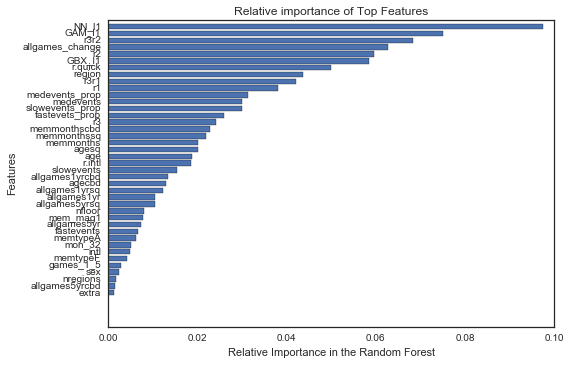

In [85]:
# HERE NOW
importance_list = full_model.feature_importances_
name_list = df_all.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
# just get top (in reverse order)
top_imp = importance_list[-40:]
top_names = name_list[-40:]
plt.barh(range(len(top_names)),top_imp,align='center')
plt.yticks(range(len(top_names)),top_names)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Top Features')
plt.show()

In [120]:
top_names

('nfloor',
 'mon_35',
 'memtypeF',
 'memtypeA',
 'fastevents',
 'allgames1yr',
 'allgames1yrsq',
 'allgames5yrcbd',
 'allgames5yrsq',
 'allgames1yrcbd',
 'allgames5yr',
 'age',
 'slowevents',
 'agecbd',
 'agesq',
 'medevents',
 'r.intl',
 'fastevets_prop',
 'memmonths',
 'memmonthssq',
 'slowevents_prop',
 'medevents_prop',
 'memmonthscbd',
 'r3',
 'region',
 'knnpreds',
 'r2',
 'r1',
 'gampreds',
 'r3r1',
 'allgames_change',
 'rf2preds',
 'r.quick',
 'r3r2',
 'glmpreds',
 'nn2preds',
 'rf1preds',
 'nn1preds',
 'svmpreds',
 'gbpolypreds')

#### Model Only

In [73]:
# parameters
estimators = [100, 250, 500] # default = 10
features = [0.6, 0.75, 0.9] # default = 'sqrt'
samples = [25, 35, 45] # default = 1
max_depth = [3, 4, 5]

for e in estimators:
    for f in features: 
        for s in samples: 
            for d in max_depth: 
                modelboost = GradientBoostingClassifier(n_estimators=e, max_features=f, min_samples_leaf=s, 
                                                   max_depth=d, random_state=1004)
                p2.get_pred_np(modelboost, df_all_stacking, train_y, 'RFBoost', track_dict=None, 
                            test_idx=test_idx, train_size=0.8, columns=None, parameters=None, 
                            score_func='log_loss', predict=False)

############
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1004, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52820
Test set error = 0.53683
----------
############
############
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1004, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52239
Test set error = 0.54181
----------
############
############
GradientBoostingClassifier(init=None, learning_rate=0

In [ ]:
# HERE NOW
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.9, max_leaf_nodes=None,
              min_samples_leaf=35, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1004, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.53040
Test set error = 0.52683

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=45, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=1004, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.51670
Test set error = 0.52702

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.75, max_leaf_nodes=None,
              min_samples_leaf=45, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=1004, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52294
Test set error = 0.52809

In [94]:
model_stacked2 = GradientBoostingClassifier(n_estimators=100, max_features=0.9, min_samples_leaf=35, max_depth=3, 
                                        random_state=1004)

In [95]:
# TODO HERE NOW
pred_stacked = p2.fit_and_predict(model_stacked2, df_all_stacking, train_y, test_idx)

In [96]:
df_all_stacking.shape

(57915, 3)

In [97]:
pred_stacked.shape

(14479,)

In [98]:
log_loss(train_y, model_stacked2.predict_proba(df_all_stacking[:test_idx])[:, 1])
# validation 0.52683
# Kaggle 

0.52926730761224206

In [100]:
model_stacked2

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.9, max_leaf_nodes=None,
              min_samples_leaf=35, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1004, subsample=1.0, verbose=0,
              warm_start=False)

In [101]:
p2.write_to_file('predictions/stacking2ndorder_gbx_no_features.csv', pred_stacked, test_ids)

### Just top 5 features + Model

- age, memmonths, R3 (and R3.na), allgames1yr, hasemail

In [76]:
df_all_top5 = df_all[['GAM_l1', 'GBX_l1', 'NN_l1', 'age', 'memmonths', 'r3', 'r3.na', 'allgames1yr', 'hasemail']]

In [77]:
df_all_top5.columns

Index([u'GAM_l1', u'GBX_l1', u'NN_l1', u'age', u'memmonths', u'r3', u'r3.na', u'allgames1yr', u'hasemail'], dtype='object')

In [78]:
df_all_top5.shape

(57915, 9)

In [79]:
# parameters
estimators = [100, 250, 500] # default = 10
features = [0.6, 0.75, 0.9] # default = 'sqrt'
samples = [25, 35, 45] # default = 1
max_depth = [3, 4, 5]

for e in estimators:
    for f in features: 
        for s in samples: 
            for d in max_depth: 
                modelboost = GradientBoostingClassifier(n_estimators=e, max_features=f, min_samples_leaf=s, 
                                                   max_depth=d, random_state=823)
                p2.get_pred_np(modelboost, df_all_top5, train_y, 'RFBoost', track_dict=None, 
                            test_idx=test_idx, train_size=0.8, columns=None, parameters=None, 
                            score_func='log_loss', predict=False)

############
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=823, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52670
Test set error = 0.53716
----------
############
############
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=823, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52047
Test set error = 0.53773
----------
############
############
GradientBoostingClassifier(init=None, learning_rate=0.1

In [ ]:
# TODO HERE NOW

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=5, max_features=0.9, max_leaf_nodes=None,
              min_samples_leaf=45, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=823, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.51519
Test set error = 0.52831


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=0.9, max_leaf_nodes=None,
              min_samples_leaf=35, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=823, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.50706
Test set error = 0.52862

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.75, max_leaf_nodes=None,
              min_samples_leaf=45, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=823, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52887
Test set error = 0.52944

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=0.9, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=823, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52151
Test set error = 0.52952

### Top 10 Features

In [89]:
name_list

('age.na',
 'games_0',
 'games_11_20',
 'games_21_34',
 'games_35_49',
 'games_50_plus',
 'games_6_10',
 'mem_mag2',
 'mon_264_plus',
 'mon_31',
 'mon_33',
 'mon_36',
 'mon_37_60',
 'mon_61_84',
 'mon_less30',
 'r.intl.na',
 'r.quick.na',
 'r1.na',
 'r2.na',
 'r3.na',
 'mon_34',
 'hasemail',
 'mon_121_263',
 'mon_35',
 'mon_85_120',
 'extra',
 'allgames5yrcbd',
 'nregions',
 'sex',
 'games_1_5',
 'memtypeF',
 'intl',
 'mon_32',
 'memtypeA',
 'fastevents',
 'allgames5yr',
 'mem_mag1',
 'nfloor',
 'allgames5yrsq',
 'allgames1yr',
 'allgames1yrsq',
 'agecbd',
 'allgames1yrcbd',
 'slowevents',
 'r.intl',
 'age',
 'agesq',
 'memmonths',
 'memmonthssq',
 'memmonthscbd',
 'r3',
 'fastevets_prop',
 'slowevents_prop',
 'medevents',
 'medevents_prop',
 'r1',
 'r3r1',
 'region',
 'r.quick',
 'GBX_l1',
 'r2',
 'allgames_change',
 'r3r2',
 'GAM_l1',
 'NN_l1')

In [91]:
top_names[-10:]

('r1',
 'r3r1',
 'region',
 'r.quick',
 'GBX_l1',
 'r2',
 'allgames_change',
 'r3r2',
 'GAM_l1',
 'NN_l1')

In [131]:
df_all.head()

,glmpreds,gampreds,rf1preds,rf2preds,nn1preds,nn2preds,gbpolypreds,svmpreds,knnpreds,age,sex,region,nregions,memmonths,mem_mag1,mem_mag2,hasemail,r1,r2,r3,r.quick,extra,intl,r.intl,allgames1yr,allgames5yr,fastevents,medevents,slowevents,nfloor,age.na,r1.na,r2.na,r3.na,r.quick.na,r.intl.na,mon_less30,mon_31,mon_32,mon_33,mon_34,mon_35,mon_36,mon_37_60,mon_61_84,mon_85_120,mon_121_263,mon_264_plus,games_0,games_1_5,games_6_10,games_11_20,games_21_34,games_35_49,games_50_plus,agesq,agecbd,allgames1yrsq,allgames1yrcbd,allgames5yrsq,allgames5yrcbd,memmonthssq,memmonthscbd,memtypeA,memtypeF,r3r2,r3r1,allgames_change,fastevets_prop,medevents_prop,slowevents_prop
0,0.94,0.94,1.00,1.00,0.95,0.95,0.94,0.78,0.92,11.00,0,0.12,1,19,0,0,0,1942.12,1811.61,1557.56,2007.74,0,0,3477.56,0,0,0,0,0,0,0,1,1,1,1,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4.97,7.45,0.00,0.00,0.00,0.00,5.99,8.99,0,0,-0.14,-0.20,-1.00,0.00,0.00,0.00
1,0.44,0.42,0.46,0.44,0.41,0.37,0.19,0.34,0.48,61.00,0,0.12,1,198,1,0,1,2178.00,2215.00,2291.00,2932.00,1,0,3477.56,4,29,1,0,10,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,8.25,12.38,3.22,4.83,6.80,10.20,10.59,15.88,0,0,0.03,0.05,-0.38,0.09,0.00,0.91
2,0.54,0.55,0.65,0.66,0.63,0.57,0.77,0.71,0.72,16.00,1,0.12,1,192,0,0,1,627.00,628.00,1362.00,2007.00,0,0,3477.56,29,29,0,4,1,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,5.67,8.50,6.80,10.20,6.80,10.20,10.53,15.79,0,0,1.17,1.17,115.00,0.00,0.80,0.20
3,0.54,0.54,0.39,0.36,0.47,0.40,0.48,0.41,0.40,47.00,0,0.12,1,268,1,0,1,2600.00,2601.00,2602.00,2007.74,0,0,3477.56,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,7.74,11.61,0.00,0.00,0.00,0.00,11.19,16.78,0,0,0.00,0.00,-1.00,0.00,0.00,0.00
4,0.89,0.88,0.83,0.83,0.83,0.85,0.82,0.82,0.68,11.00,1,0.12,1,101,0,0,0,464.00,466.00,958.00,1356.00,0,0,3477.56,12,35,0,8,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,4.97,7.45,5.13,7.69,7.17,10.75,9.25,13.87,0,0,1.06,1.06,1.00,0.00,1.00,0.00


In [136]:
list(top_names[-20:])

['slowevents_prop',
 'medevents_prop',
 'memmonthscbd',
 'r3',
 'region',
 'knnpreds',
 'r2',
 'r1',
 'gampreds',
 'r3r1',
 'allgames_change',
 'rf2preds',
 'r.quick',
 'r3r2',
 'glmpreds',
 'nn2preds',
 'rf1preds',
 'nn1preds',
 'svmpreds',
 'gbpolypreds']

In [92]:
df_all_top10 = df_all[list(top_names[-10:])]

In [93]:
# HERE NOW
# parameters
estimators = [100, 250, 500] # default = 10
features = [0.6, 0.75, 0.9] # default = 'sqrt'
samples = [25, 35, 45] # default = 1
max_depth = [3, 4, 5]

for e in estimators:
    for f in features: 
        for s in samples: 
            for d in max_depth: 
                model_top = GradientBoostingClassifier(n_estimators=e, max_features=f, min_samples_leaf=s, 
                                                   max_depth=d, random_state=616)
                p2.get_pred_np(model_top, df_all_top10, train_y, 'RFBoost', track_dict=None, 
                            test_idx=test_idx, train_size=0.8, columns=None, parameters=None, 
                            score_func='log_loss', predict=False)


############
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=616, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52630
Test set error = 0.53893
----------
############
############
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=25, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=616, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.51850
Test set error = 0.54301
----------
############
############
GradientBoostingClassifier(init=None, learning_rate=0.1

In [ ]:
# TODO HERE NOW

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.6, max_leaf_nodes=None,
              min_samples_leaf=35, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=616, subsample=1.0, verbose=0,
              warm_start=False)
----------
Training set error = 0.52920
Test set error = 0.52811